# Parameter-Efficient Fine-Tuning with LoRA

This notebook demonstrates how to use **LoRA (Low-Rank Adaptation)** to fine-tune a pretrained GPT-2 model efficiently. LoRA reduces memory usage and computational costs by freezing most model parameters and training small, low-rank matrices.

In [1]:
# Install required libraries
# !pip install transformers datasets peft torch

## Step 1: Load Pretrained GPT-2 Model and Tokenizer

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load GPT-2 model and tokenizer
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Print model summary
print("Model loaded successfully!")

/Users/ahb/Documents/projects/Udacity Author/Micro Lesson/Exercise/udacity_micro_lesson/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


## Step 2: Apply LoRA Configuration to the Model

In [3]:
from peft import LoraConfig, get_peft_model

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,            # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["c_attn", "c_proj"],  # Target attention layers
    lora_dropout=0.1,
) 

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print confirmation
print("LoRA applied successfully!")

LoRA applied successfully!


/Users/ahb/Documents/projects/Udacity Author/Micro Lesson/Exercise/udacity_micro_lesson/.venv/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## Step 3: Load and Tokenize Dataset

In [4]:
from datasets import load_dataset

# Load a small dataset (e.g., WikiText)
dataset = load_dataset('wikitext', 'wikitext-2-v1', split='train[:1%]')

# Set an existing token (e.g., eos_token) as the padding token (The GPT-2 tokenizer already has an eos_token (End of Sequence) that can serve as a padding token)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Convert tokenized dataset to PyTorch tensors
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Print confirmation
print("Dataset tokenized successfully!")

Dataset tokenized successfully!


## Step 4: Simulate Training with LoRA

In [7]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

# Prepare data loader
data_loader = DataLoader(tokenized_dataset, batch_size=4)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Initialize an empty list to store the loss values
losses = []

# Training loop
for epoch in range(1):
    print(f"Starting epoch {epoch + 1}")
    for batch in data_loader:
        inputs = batch["input_ids"].to(model.device)
        labels = inputs.clone()
        
        # Forward pass
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        losses.append(loss.item())  # Store the loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print(f"Loss: {loss.item()}")
    print(f"Epoch {epoch + 1} completed!")


Starting epoch 1
Loss: 11.213605880737305
Loss: 9.260119438171387
Loss: 7.137081146240234
Loss: 11.074289321899414
Loss: 8.74384593963623
Loss: 7.979244709014893
Loss: 10.354158401489258
Loss: 8.383377075195312
Loss: 10.833468437194824
Loss: 6.526091575622559
Loss: 10.141081809997559
Loss: 7.352585792541504
Loss: 8.3993558883667
Loss: 6.797913551330566
Loss: 7.332984924316406
Loss: 6.358208656311035
Loss: 6.100376605987549
Loss: 7.775653839111328
Loss: 6.942566394805908
Loss: 6.865119457244873
Loss: 5.502302646636963
Loss: 4.898306369781494
Loss: 4.464327335357666
Loss: 5.17969274520874
Loss: 3.853623867034912
Loss: 3.3632638454437256
Loss: 2.8544232845306396
Loss: 3.4212331771850586
Loss: 2.706090211868286
Loss: 2.584737777709961
Loss: 2.5216493606567383
Loss: 1.6283177137374878
Loss: 2.680100440979004
Loss: 1.5542430877685547
Loss: 2.5166306495666504
Loss: 0.47972792387008667
Loss: 2.2414815425872803
Loss: 2.5684421062469482
Loss: 1.3044382333755493
Loss: 1.3398805856704712
Loss: 2.5

# Plot the loss values


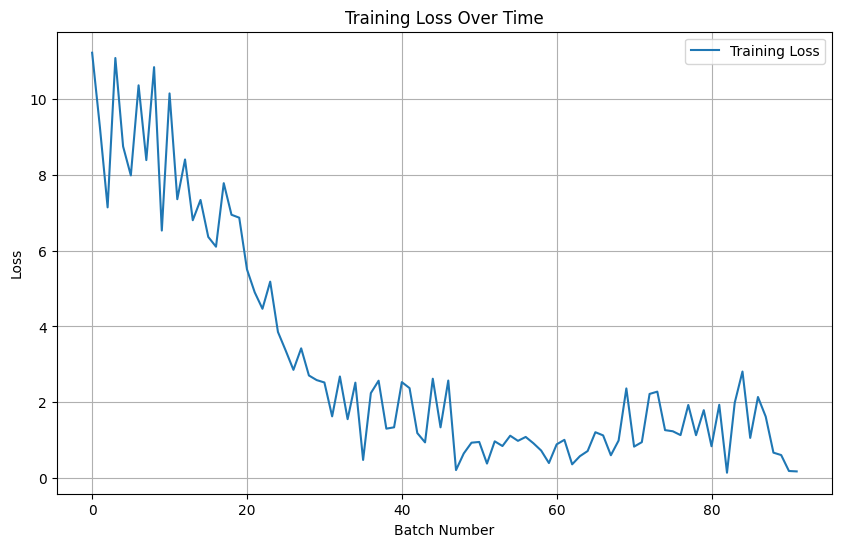

In [8]:
# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()
